 <font size="15">Deep Movement </font>

<font size="6">Last updated  March 30, 2022 </font>






We have developed a model that takes as input a video of a cerebral DSA and identify the presence or absence of large vessel occlusion (LVO), locate the level of occlusion and assess the success of thrombectomy. The proposed task contains two elements which add temporal complexity: there is the dynamic nature of the DSA run that changes frame by frame, and also the change detection element, comparing pre and post intervention runs. Here we detail the model architecture.




In [1]:
import numpy as np
import h5py
import tensorflow as tf
# This is the post intervention set
f1 = h5py.File('stroke_post_N_52_ICA_42_M1_102_M_72_v2.h5', 'r')
list(f1.keys())
videos_ICA = f1['x_ICA']
labels_ICA = f1['y_ICA']
videos_m1 = f1['x_m1']
labels_m1 = f1['y_m1']
videos_m2 = f1['x_m2']
labels_m2 = f1['y_m2']
videos_test = np.concatenate((videos_normal, videos_ICA, videos_m1, videos_m2))
labels_test = np.concatenate((labels_normal, labels_ICA, labels_m1, labels_m2))
BATCH_SIZE = 16
n_test = len(labels_test)
    
    

(52, 10, 200, 200, 3)
(52,)
(46, 10, 200, 200, 3)
(46,)
ica: <HDF5 dataset "y_ICA": shape (46,), type "<i8">
(109, 10, 200, 200, 3)
(109,)
m1: <HDF5 dataset "y_m1": shape (109,), type "<i8">
(80, 10, 200, 200, 3)
(80,)
m2 <HDF5 dataset "y_m2": shape (80,), type "<i8">
(287, 10, 200, 200, 3)
(287,)
255
0


In [8]:
import os
import numpy as np
import glob
import sys
import scipy.io as io

import  tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, Concatenate, Input, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU,GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Concatenate, Input, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.layers import Multiply, Add
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras import backend as K

@tf.function
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    label = tf.cast(label, tf.float32)
    print(image.shape)
    ys = []
    for i in range(10):
        image_2d = image[i,:,:,:]
        image_2d = tf.image.random_brightness(image_2d, max_delta=0.1)
        print(image_2d.shape)
        image_2d = tf.image.random_flip_left_right(image_2d)
        ys.append(image_2d)
    ys = tf.convert_to_tensor(ys, dtype=tf.float32)
    return ys, label

val_dataset = tf.data.Dataset.from_tensor_slices((videos_test,labels_test))
val_dataset = val_dataset.map(scale, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)

 

(10, 200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)


In [9]:
def cap_out():
    inputs = tf.keras.layers.Input(shape=[2048])
    hidden = tf.keras.layers.Flatten()(inputs)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    hidden = tf.keras.layers.Dropout(GLOBAL_DROPOUT)(hidden)
    hidden = tf.keras.layers.Dense(64)(hidden)
    cap=tf.keras.Model(inputs = inputs, outputs = hidden)
    return cap
GLOBAL_DROPOUT = 0.5
def _stacked_model():
    inputs = tf.keras.layers.Input(shape=[10,200,200, 3])
    base_model = tf.keras.applications.Xception(weights= 'imagenet',
                                                include_top=False, 
                                                input_shape= (200,200,3))
    base_model.trainable = True
    
    inputs_frame0 = tf.keras.layers.Lambda(lambda x: x[:,0,:,:,:])(inputs)
    inputs_frame1 = tf.keras.layers.Lambda(lambda x: x[:,1,:,:,:])(inputs)
    inputs_frame2 = tf.keras.layers.Lambda(lambda x: x[:,2,:,:,:])(inputs)
    inputs_frame3 = tf.keras.layers.Lambda(lambda x: x[:,3,:,:,:])(inputs)
    inputs_frame4 = tf.keras.layers.Lambda(lambda x: x[:,4,:,:,:])(inputs)
    inputs_frame5 = tf.keras.layers.Lambda(lambda x: x[:,5,:,:,:])(inputs)
    inputs_frame6 = tf.keras.layers.Lambda(lambda x: x[:,6,:,:,:])(inputs)
    inputs_frame7 = tf.keras.layers.Lambda(lambda x: x[:,7,:,:,:])(inputs)
    inputs_frame8 = tf.keras.layers.Lambda(lambda x: x[:,8,:,:,:])(inputs)
    inputs_frame9 = tf.keras.layers.Lambda(lambda x: x[:,9,:,:,:])(inputs)

    feature_batch0 = base_model(inputs_frame0)
    x0 = tf.keras.layers.GlobalAveragePooling2D()(feature_batch0)
    feature_batch1 = base_model(inputs_frame1)
    x1 = tf.keras.layers.GlobalAveragePooling2D()(feature_batch1)
    feature_batch2 = base_model(inputs_frame2)
    x2 = tf.keras.layers.GlobalAveragePooling2D()(feature_batch2)
    feature_batch3 = base_model(inputs_frame3)
    x3 = tf.keras.layers.GlobalAveragePooling2D()(feature_batch3)
    feature_batch4 = base_model(inputs_frame4)
    x4 = tf.keras.layers.GlobalAveragePooling2D()(feature_batch4)
    feature_batch5 = base_model(inputs_frame5)
    x5 = tf.keras.layers.GlobalAveragePooling2D()(feature_batch5)
    feature_batch6 = base_model(inputs_frame6)
    x6 = tf.keras.layers.GlobalAveragePooling2D()(feature_batch6)
    feature_batch7 = base_model(inputs_frame7)
    x7 = tf.keras.layers.GlobalAveragePooling2D()(feature_batch7)
    feature_batch8 = base_model(inputs_frame8)
    x8 = tf.keras.layers.GlobalAveragePooling2D()(feature_batch8)
    feature_batch9 = base_model(inputs_frame9)
    x9 = tf.keras.layers.GlobalAveragePooling2D()(feature_batch9)
    
    
    cap = cap_out()
    x0 = cap(x0)
    x1 = cap(x1)
    x2 = cap(x2)
    x3 = cap(x3)
    x4 = cap(x4)
    x5 = cap(x5)
    x6 = cap(x6)
    x7 = cap(x7)
    x8 = cap(x8)
    x9 = cap(x9)
    combined = tf.keras.layers.Average()([x0, x1,x2,x3,x4,x5,x6,x7,x8,x9])
    
    hidden = tf.keras.layers.BatchNormalization()(combined)    
    hidden = tf.keras.layers.Dropout(GLOBAL_DROPOUT)(hidden)
    hidden = tf.keras.layers.Activation('relu')(hidden)
    hidden = tf.keras.layers.Dense(4)(hidden)
    hidden = tf.keras.layers.Activation('softmax')(hidden)

    model=tf.keras.Model(inputs = inputs, outputs = hidden)
    base_learning_rate = 0.001
    initial_learning_rate = base_learning_rate
    return model


tf.keras.backend.clear_session()
model = _stacked_model() 


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 200, 200 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 200, 200, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 200, 200, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 200, 200, 3)  0           input_1[0][0]                    
____________________________________________________________________________________________

In [16]:
from sklearn.metrics import plot_confusion_matrix
model.load_weights("saved_weights.h5")


In [ ]:
import scipy.io as io
 

val_dataset = tf.data.Dataset.from_tensor_slices((videos_test,labels_test))
val_dataset = val_dataset.map(scale, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(1)

 
def evaluate_test(dataset=None, num=1):
    class_acc= 0.0
    num_idx= 0.0
    labels = []
    preds = []
    for image, label in dataset.take(num):
      class_pred = model.predict(image)
      for idx in range(len(class_pred)):
        pred_class = class_pred[idx]
        true_class = label[idx]
        labels.append(true_class)
        preds.append(pred_class)
        if (np.argmax(pred_class) == true_class):
          class_acc += 1.0
        num_idx += 1.0
    class_acc_tot = class_acc / num_idx
    return  class_acc_tot, labels, preds

acc, labels_, preds_ = evaluate_test(val_dataset, num= 22+10)
preds = []
labels = []
for i in range(len(preds_)):
    labels.append(labels_[i].numpy())
    preds.append(np.argmax(preds_[i]))

a={}
a['train']=np.array(train_losses_np)
a['eval']=np.array(eval_losses_np_new)
a['eval_acc']=np.array(acc)
a['labels']=np.array(labels)
a['preds']=np.array(preds)
filename_out = "trainOnPre_testOnPost_3d_acc_" + str(acc) + "_test1_.mat"
io.savemat(filename_out, a)



The model trained on pre intervention runs are evaluated on the post intervention run below, and the confusion matrix is shown quantifying the success of the thrombectomy. 

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

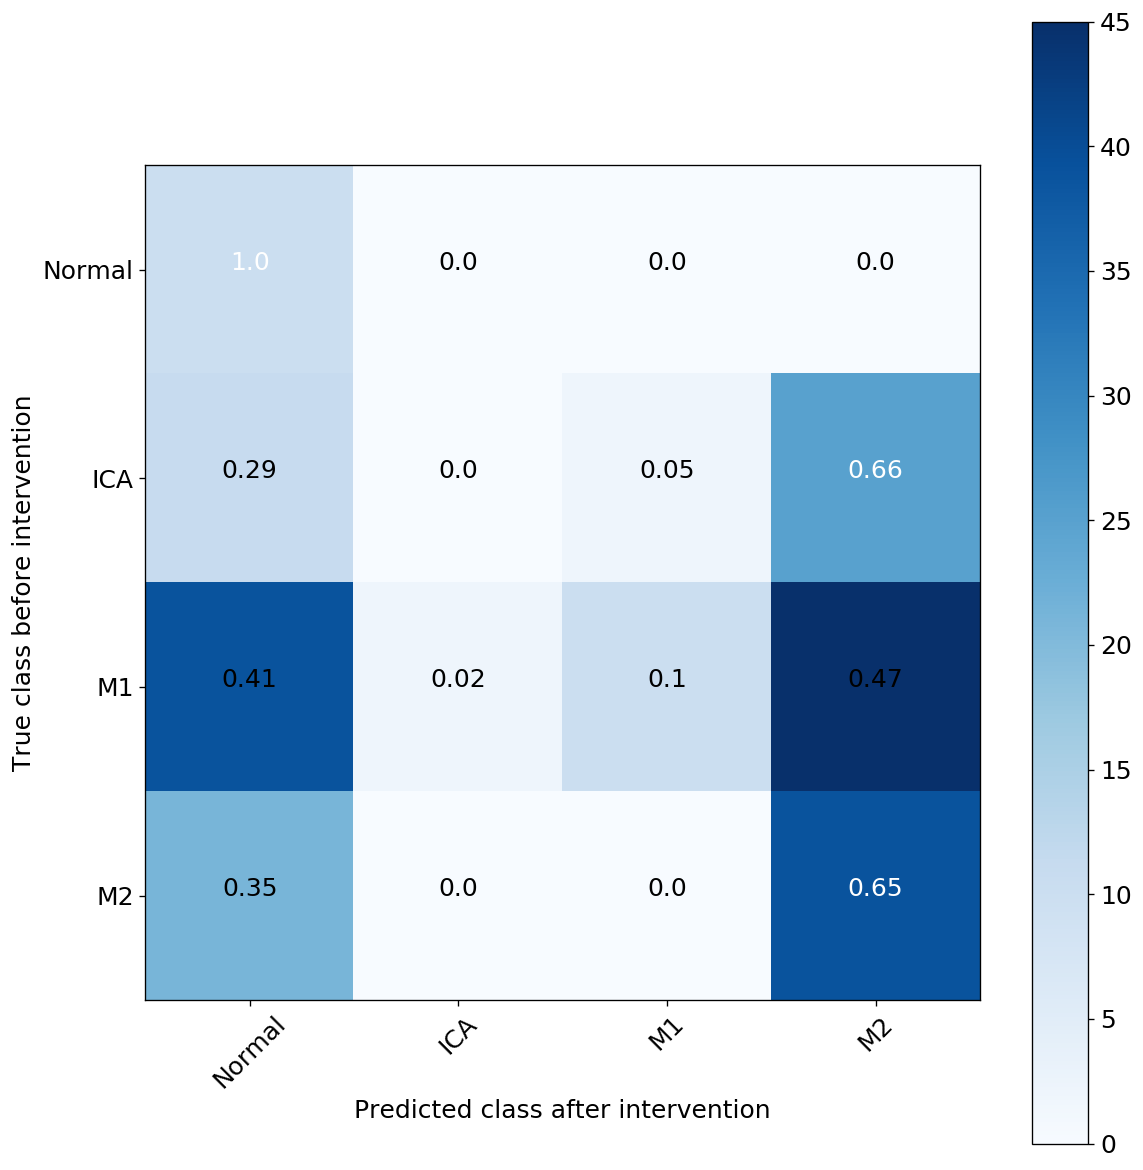

In [39]:
import scipy.io as sio
# labels_test2 and preds_test2 represent the model predicted on the post-intervention set:

labels=np.array(labels_test2)
preds =np.array(preds_test2)

true_classes =labels.squeeze()
predicted_classes = preds.squeeze()
import numpy as np
import matplotlib.pyplot as plt
import sklearn 
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import itertools
# Calculate the confusion matrix.
cm = sklearn.metrics.confusion_matrix(true_classes, predicted_classes)
from sklearn.metrics import f1_score, accuracy_score
f1_score_ = f1_score(true_classes, predicted_classes, average='macro')

from matplotlib.pyplot import figure
plt.rcParams.update({'font.size': 15})
figure(num=None, figsize=(5, 5), dpi=120, facecolor='w', edgecolor='k')
def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
#   figure = plt.figure(figsize=(8, 8))
  figure(num=None, figsize=(10, 10), dpi=120, facecolor='w', edgecolor='k')
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#   plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Normalize the confusion matrix.
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True class before intervention')
  plt.xlabel('Predicted class after intervention')
  return figure


from matplotlib.pyplot import figure
plt.rcParams.update({'font.size': 15})
ax_=figure(num=None, figsize=(5, 5), dpi=120, facecolor='w', edgecolor='k')

figure = plot_confusion_matrix(cm, class_names=["Normal","ICA","M1","M2"])

